In [2]:
# ------------------------
# 1) Imports & device
# ------------------------
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt
from typing import Tuple

# import preprocessing helpers you were given (assignment3_utils.py)
from assignment3_utils import img_crop, downsample, to_grayscale, normalize_grayscale

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
# ------------------------
# 2) Preprocessing & frame stacking
# ------------------------
IMAGE_H, IMAGE_W = 84, 80  # target frame size after crop+downsample

def preprocess_frame(frame: np.ndarray) -> np.ndarray:
    """
    Convert raw 210x160x3 frame to grayscale normalized 84x80 float32.
    Uses provided helpers in assignment3_utils.py
    """
    img = img_crop(frame)               # crop top/bottom
    img = downsample(img)               # downsample -> ~84x80
    img = to_grayscale(img)             # convert to grayscale
    img = normalize_grayscale(img)      # normalize to roughly [-1,1]
    return img.astype(np.float32)       # (84,80)

def init_state(first_obs: np.ndarray) -> np.ndarray:
    """Return stacked initial state of shape (4, 84, 80)."""
    f = preprocess_frame(first_obs)
    return np.stack([f] * 4, axis=0)

def update_state(state: np.ndarray, new_obs: np.ndarray) -> np.ndarray:
    """Shift stack left and append new processed frame at end."""
    f = preprocess_frame(new_obs)
    new_state = np.roll(state, shift=-1, axis=0)
    new_state[-1] = f
    return new_state


In [4]:
# ------------------------
# 3) Replay Buffer
# ------------------------
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, ns, d):
        # store numpy arrays to avoid retaining references from env
        self.buffer.append((np.array(s, copy=False), int(a), float(r), np.array(ns, copy=False), float(d)))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


In [5]:
# ------------------------
# 4) DQN Model (3 conv layers)
# ------------------------
class DQN(nn.Module):
    def __init__(self, action_size: int):
        super(DQN, self).__init__()
        # first conv in_channels = 4 because we stack 4 frames
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # compute conv output size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 4, IMAGE_H, IMAGE_W)
            x = F.relu(self.conv1(dummy))
            x = F.relu(self.conv2(x))
            x = F.relu(self.conv3(x))
            conv_out = x.view(1, -1).size(1)

        self.fc1 = nn.Linear(conv_out, 512)
        self.fc2 = nn.Linear(512, action_size)

    def forward(self, x):
        # x: (batch, 4, H, W)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [6]:
# ------------------------
# 5) Training function
# ------------------------
def train_dqn(batch_size=8, target_update_ep=10, episodes=25,
              replay_capacity=100000, lr=2.5e-4, frameskip=4):
    """
    Trains DQN and returns (steps_list, scores_list, avg5_list, online_net)
    Default hyperparams match assignment:
    gamma=0.95, eps_decay=0.995, eps_min=0.05
    """
    # create env (Gymnasium)
    env = gym.make("ALE/Pong-v5", render_mode=None, frameskip=frameskip)
    action_size = env.action_space.n
    print("Env action space:", env.action_space, "n=", action_size)

    online = DQN(action_size).to(device)
    target = DQN(action_size).to(device)
    target.load_state_dict(online.state_dict())

    optimizer = optim.Adam(online.parameters(), lr=lr)
    buffer = ReplayBuffer(replay_capacity)

    # assignment hyperparams
    gamma = 0.95
    epsilon = 1.0
    eps_min = 0.05
    eps_decay = 0.995

    steps = []
    scores = []
    avg5 = []
    global_step = 0

    for ep in range(1, episodes + 1):
        obs, _ = env.reset()
        state = init_state(obs)
        done = False
        ep_reward = 0

        while not done:
            global_step += 1

            # epsilon-greedy
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                s_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                q_vals = online(s_tensor)
                action = int(torch.argmax(q_vals, dim=1).item())

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = bool(terminated or truncated)

            next_state = update_state(state, next_obs)
            buffer.push(state, action, reward, next_state, float(done))

            state = next_state
            ep_reward += reward

            # optimize
            if len(buffer) > batch_size * 4:
                states_b, actions_b, rewards_b, next_states_b, dones_b = buffer.sample(batch_size)

                # to device
                states_b = states_b.to(device)
                next_states_b = next_states_b.to(device)
                actions_b = actions_b.to(device)
                rewards_b = rewards_b.to(device)
                dones_b = dones_b.to(device)

                qvals = online(states_b)
                q_selected = qvals.gather(1, actions_b.unsqueeze(1)).squeeze(1)
                q_next = target(next_states_b).max(1)[0].detach()
                target_q = rewards_b + (1.0 - dones_b) * gamma * q_next

                loss = F.smooth_l1_loss(q_selected, target_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # end of episode
        epsilon = max(eps_min, epsilon * eps_decay)
        if ep % target_update_ep == 0:
            target.load_state_dict(online.state_dict())

        scores.append(ep_reward)
        avg5.append(float(np.mean(scores[-5:])))
        steps.append(global_step)

        print(f"Ep {ep:3d} | Step {global_step:6d} | Reward {ep_reward:4.1f} | Avg5 {avg5[-1]:5.2f} | ε={epsilon:5.3f}")

    env.close()
    return steps, scores, avg5, online


In [7]:
# ------------------------
# 6) Plotting helpers
# ------------------------
def plot_metrics(steps, scores, avg5, title="Metrics"):
    plt.figure(figsize=(10,5))
    plt.plot(scores, label="Score per episode")
    plt.plot(avg5, label="Average (last 5)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(steps)
    plt.xlabel("Episode")
    plt.ylabel("Cumulative steps")
    plt.title(title + " - Steps")
    plt.grid(True)
    plt.show()


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Env action space: Discrete(6) n= 6
Ep   1 | Step    852 | Reward -21.0 | Avg5 -21.00 | ε=0.995
Ep   2 | Step   1616 | Reward -21.0 | Avg5 -21.00 | ε=0.990
Ep   3 | Step   2468 | Reward -21.0 | Avg5 -21.00 | ε=0.985
Ep   4 | Step   3445 | Reward -19.0 | Avg5 -20.50 | ε=0.980
Ep   5 | Step   4209 | Reward -21.0 | Avg5 -20.60 | ε=0.975
Ep   6 | Step   4992 | Reward -21.0 | Avg5 -20.60 | ε=0.970
Ep   7 | Step   5879 | Reward -20.0 | Avg5 -20.40 | ε=0.966
Ep   8 | Step   7059 | Reward -18.0 | Avg5 -19.80 | ε=0.961
Ep   9 | Step   7901 | Reward -20.0 | Avg5 -20.00 | ε=0.956
Ep  10 | Step   8969 | Reward -20.0 | Avg5 -19.80 | ε=0.951
Ep  11 | Step   9900 | Reward -20.0 | Avg5 -19.60 | ε=0.946
Ep  12 | Step  10664 | Reward -21.0 | Avg5 -19.80 | ε=0.942
Ep  13 | Step  11776 | Reward -20.0 | Avg5 -20.20 | ε=0.937
Ep  14 | Step  12540 | Reward -21.0 | Avg5 -20.40 | ε=0.932
Ep  15 | Step  13411 | Reward -20.0 | Avg5 -20.40 | ε=0.928
Ep  16 | Step  14435 | Reward -21.0 | Avg5 -20.60 | ε=0.923
Ep  1

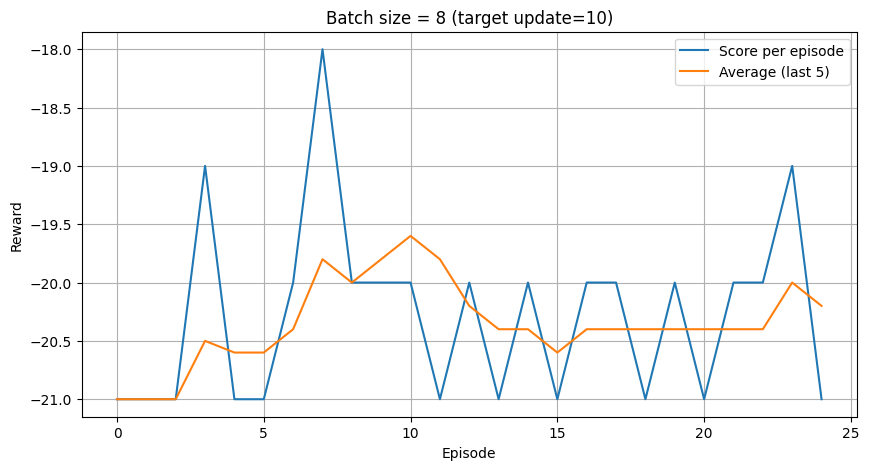

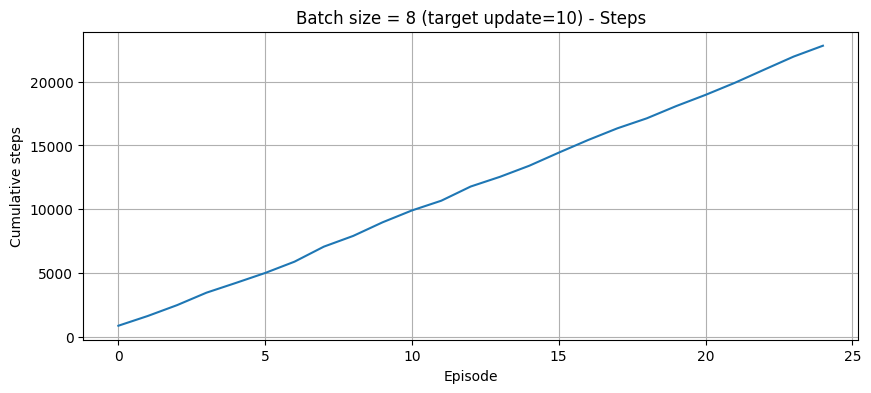

Env action space: Discrete(6) n= 6
Ep   1 | Step    898 | Reward -20.0 | Avg5 -20.00 | ε=0.995
Ep   2 | Step   1709 | Reward -21.0 | Avg5 -20.50 | ε=0.990
Ep   3 | Step   2640 | Reward -20.0 | Avg5 -20.33 | ε=0.985
Ep   4 | Step   3404 | Reward -21.0 | Avg5 -20.50 | ε=0.980
Ep   5 | Step   4386 | Reward -20.0 | Avg5 -20.40 | ε=0.975
Ep   6 | Step   5345 | Reward -21.0 | Avg5 -20.60 | ε=0.970
Ep   7 | Step   6199 | Reward -21.0 | Avg5 -20.60 | ε=0.966
Ep   8 | Step   7194 | Reward -19.0 | Avg5 -20.40 | ε=0.961
Ep   9 | Step   8176 | Reward -20.0 | Avg5 -20.20 | ε=0.956
Ep  10 | Step   8940 | Reward -21.0 | Avg5 -20.40 | ε=0.951
Ep  11 | Step  10046 | Reward -20.0 | Avg5 -20.20 | ε=0.946
Ep  12 | Step  10932 | Reward -21.0 | Avg5 -20.20 | ε=0.942
Ep  13 | Step  11925 | Reward -20.0 | Avg5 -20.40 | ε=0.937
Ep  14 | Step  12811 | Reward -21.0 | Avg5 -20.60 | ε=0.932
Ep  15 | Step  13664 | Reward -21.0 | Avg5 -20.60 | ε=0.928
Ep  16 | Step  14812 | Reward -20.0 | Avg5 -20.60 | ε=0.923
Ep  1

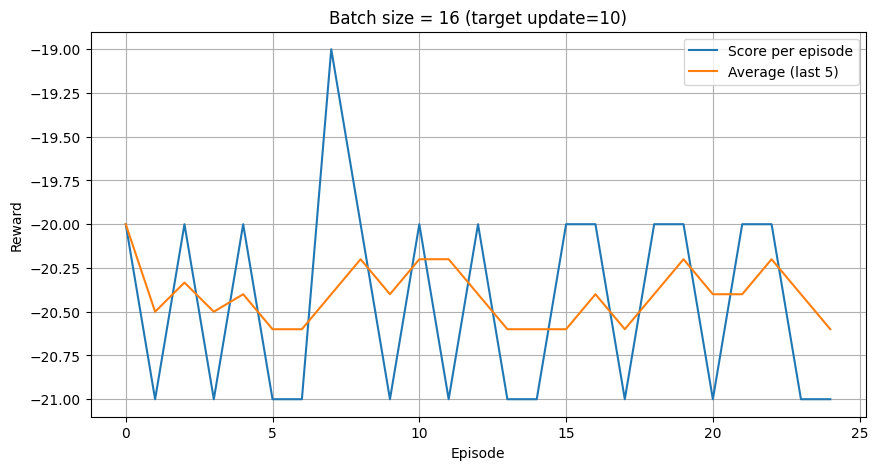

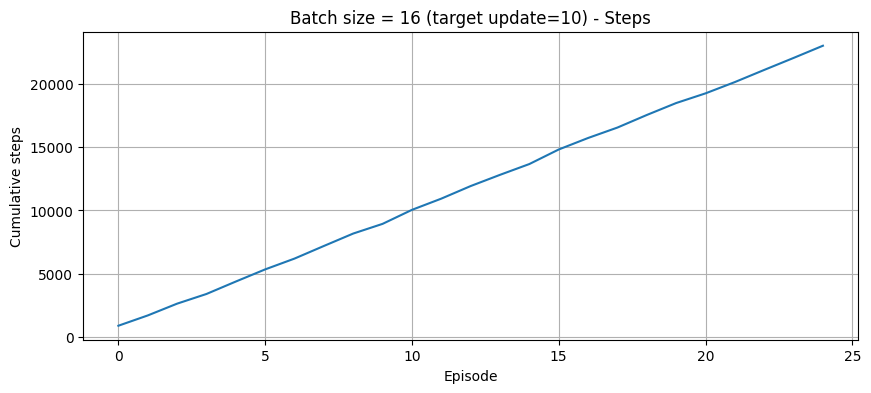

Env action space: Discrete(6) n= 6
Ep   1 | Step    902 | Reward -20.0 | Avg5 -20.00 | ε=0.995
Ep   2 | Step   1861 | Reward -20.0 | Avg5 -20.00 | ε=0.990
Ep   3 | Step   2928 | Reward -21.0 | Avg5 -20.33 | ε=0.985
Ep   4 | Step   3692 | Reward -21.0 | Avg5 -20.50 | ε=0.980
Ep   5 | Step   4854 | Reward -19.0 | Avg5 -20.20 | ε=0.975
Ep   6 | Step   5676 | Reward -21.0 | Avg5 -20.40 | ε=0.970
Ep   7 | Step   6519 | Reward -20.0 | Avg5 -20.40 | ε=0.966
Ep   8 | Step   7431 | Reward -21.0 | Avg5 -20.40 | ε=0.961
Ep   9 | Step   8393 | Reward -21.0 | Avg5 -20.40 | ε=0.956
Ep  10 | Step   9298 | Reward -20.0 | Avg5 -20.60 | ε=0.951
Ep  11 | Step  10223 | Reward -20.0 | Avg5 -20.40 | ε=0.946
Ep  12 | Step  11047 | Reward -21.0 | Avg5 -20.60 | ε=0.942
Ep  13 | Step  11950 | Reward -20.0 | Avg5 -20.40 | ε=0.937
Ep  14 | Step  12851 | Reward -20.0 | Avg5 -20.20 | ε=0.932
Ep  15 | Step  13859 | Reward -20.0 | Avg5 -20.20 | ε=0.928
Ep  16 | Step  14623 | Reward -21.0 | Avg5 -20.40 | ε=0.923
Ep  1

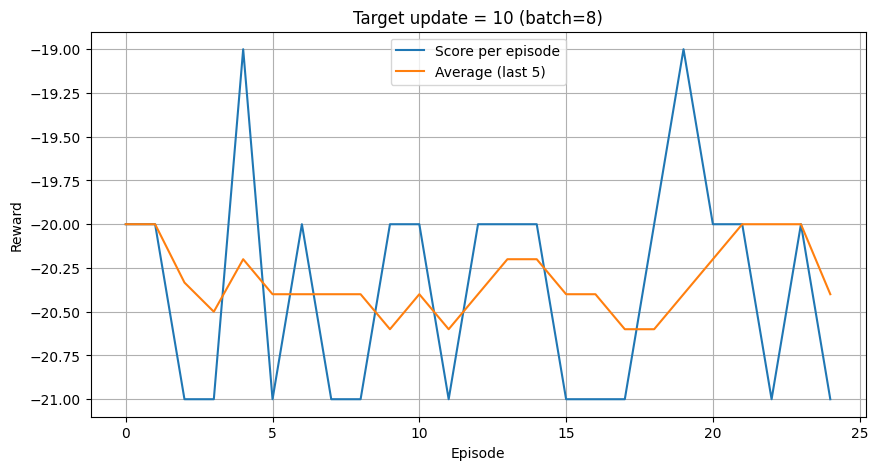

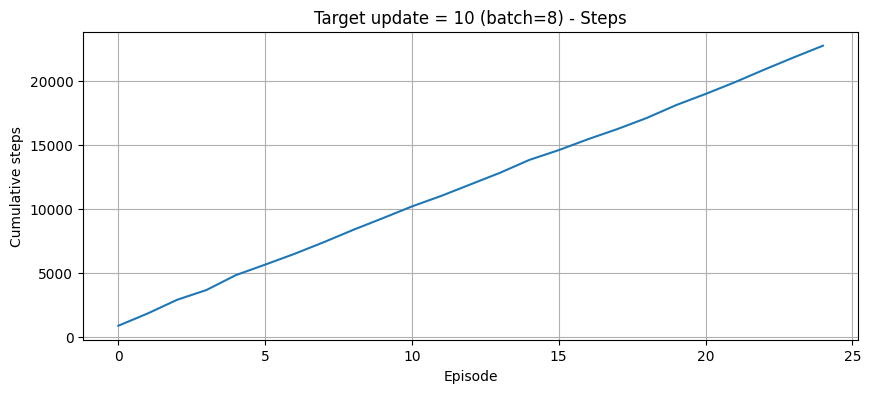

Env action space: Discrete(6) n= 6
Ep   1 | Step    880 | Reward -21.0 | Avg5 -21.00 | ε=0.995
Ep   2 | Step   1855 | Reward -20.0 | Avg5 -20.50 | ε=0.990
Ep   3 | Step   2735 | Reward -21.0 | Avg5 -20.67 | ε=0.985
Ep   4 | Step   3634 | Reward -20.0 | Avg5 -20.50 | ε=0.980
Ep   5 | Step   4646 | Reward -19.0 | Avg5 -20.20 | ε=0.975
Ep   6 | Step   5530 | Reward -21.0 | Avg5 -20.20 | ε=0.970
Ep   7 | Step   6400 | Reward -20.0 | Avg5 -20.20 | ε=0.966
Ep   8 | Step   7238 | Reward -20.0 | Avg5 -20.00 | ε=0.961
Ep   9 | Step   8083 | Reward -21.0 | Avg5 -20.20 | ε=0.956
Ep  10 | Step   8953 | Reward -21.0 | Avg5 -20.60 | ε=0.951
Ep  11 | Step   9884 | Reward -20.0 | Avg5 -20.40 | ε=0.946
Ep  12 | Step  10676 | Reward -21.0 | Avg5 -20.60 | ε=0.942
Ep  13 | Step  11589 | Reward -20.0 | Avg5 -20.60 | ε=0.937
Ep  14 | Step  12533 | Reward -19.0 | Avg5 -20.20 | ε=0.932
Ep  15 | Step  13353 | Reward -21.0 | Avg5 -20.20 | ε=0.928
Ep  16 | Step  14290 | Reward -20.0 | Avg5 -20.20 | ε=0.923
Ep  1

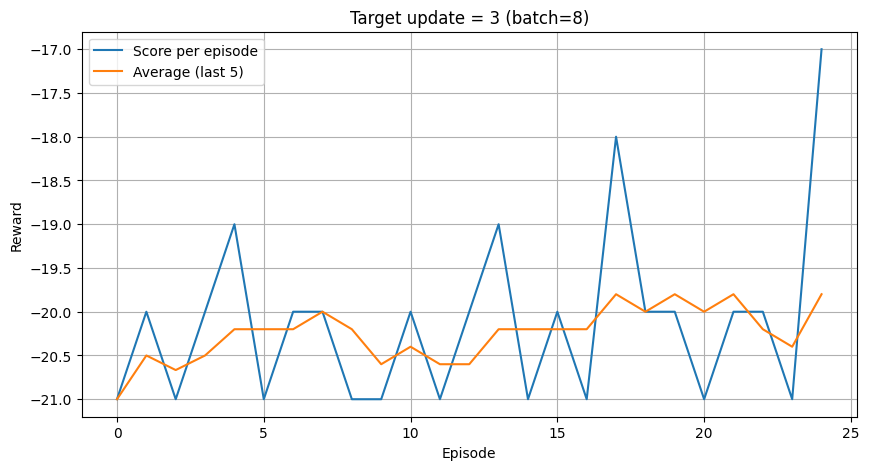

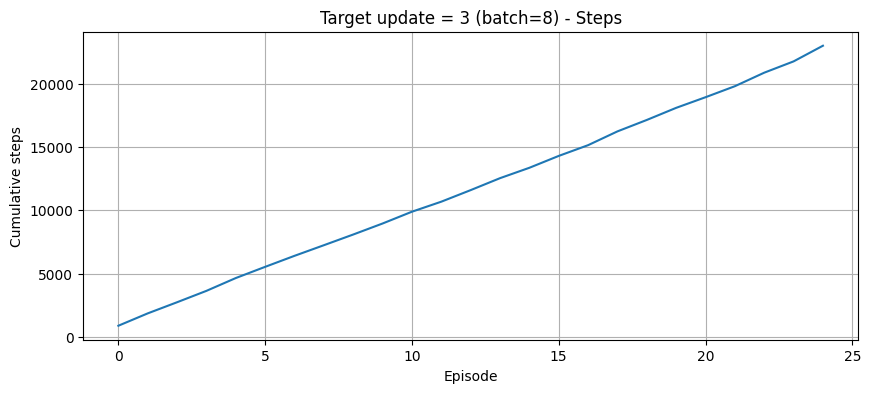

Saved model to dqn_pong_final.pth


In [8]:
# ------------------------
# 7) Run experiments (recommended defaults)
# ------------------------
# Quick smoke test (2 episodes) to confirm everything loads:
# steps_test, scores_test, avg_test, _ = train_dqn(batch_size=8, target_update_ep=10, episodes=2)
# plot_metrics(steps_test, scores_test, avg_test, "Smoke test (2 eps)")

# === Batch size experiment: batch=8 vs batch=16 (target update = 10) ===
steps_b8, scores_b8, avg_b8, net_b8 = train_dqn(batch_size=8,  target_update_ep=10, episodes=25)
plot_metrics(steps_b8, scores_b8, avg_b8, "Batch size = 8 (target update=10)")

steps_b16, scores_b16, avg_b16, net_b16 = train_dqn(batch_size=16, target_update_ep=10, episodes=25)
plot_metrics(steps_b16, scores_b16, avg_b16, "Batch size = 16 (target update=10)")

# === Target update experiment: update=10 vs update=3 (batch size = 8) ===
steps_t10, scores_t10, avg_t10, net_t10 = train_dqn(batch_size=8, target_update_ep=10, episodes=25)
plot_metrics(steps_t10, scores_t10, avg_t10, "Target update = 10 (batch=8)")

steps_t3,  scores_t3,  avg_t3,  net_t3  = train_dqn(batch_size=8, target_update_ep=3, episodes=25)
plot_metrics(steps_t3, scores_t3, avg_t3, "Target update = 3 (batch=8)")

# Save a model example
torch.save(net_b8.state_dict(), "dqn_pong_final.pth")
print("Saved model to dqn_pong_final.pth")
